In [1]:
import numpy as np
import matplotlib.pyplot as plt

import joblib

import random
from deap import base
from deap import creator
from deap import tools

from deap import algorithms
from time import time
import multiprocessing

import array
import random
import json

import os

import pandas as pd

In [2]:
matrix_np = joblib.load('matrix_np.pkl')

In [3]:
#reduced_matrix_np = joblib.load('reduced_matrix_np.pkl')

# Parameters

In [4]:
matrix_algorithm = matrix_np
NUM_CLUSTERS = 7

# Distance to cluster function

In [5]:
def auxiliarFunction(documents, dimensions, number_topics):

    counter_docs = [0 for x in range(0,number_topics)]
    
    distance_to_cluster_2 = [0 for x in range(0,number_topics)] # distances to cluster
    
    for document in documents: 
        distance_to_cluster = []   
        counter = 0
        for dim in range(0,number_topics): 
            distance_to_cluster.append(np.linalg.norm(document-dimensions[counter:counter+7]))
            counter = counter + 7
            
        best_distance_index = distance_to_cluster.index(min(distance_to_cluster)) 
        
        counter_docs[best_distance_index] += 1
    
        distance_to_cluster_2[best_distance_index] += pow(distance_to_cluster[best_distance_index], 2)
        
     
    return counter_docs, distance_to_cluster_2

In [6]:
def fobjQuadraticError(k):

    num_topics = int((len(k))/7)
    
    # 1º Number of documents to each cluster
    counter_documents, euclidean_dist_2 = auxiliarFunction(documents = matrix_algorithm, dimensions= k, number_topics = num_topics)
    
    bool_check = 0 in counter_documents    

   # 2º Fitness fuction
    if(bool_check):
        total_value = 5 # We give a high value to those clusters who do not have documents
        
    else:
        value1 = 0
        for i in range(0,num_topics): 
            value2 = euclidean_dist_2[i] 
            value1 += ((1/counter_documents[i])*value2)

        total_value = (value1 / num_topics) 

    return (total_value),

# Genetic Algorithm

## Folders creation

In [7]:
path = "./results/fobjQuadraticError"
try:
    if not os.path.isdir(path):
        os.makedirs(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

Successfully created the directory ./results/fobjQuadraticError 


## Genetic Operators

### Initial Population

In [8]:
def load_individuals(creator,n):
    individuals = []
    ones = [0 for x in range(0,49)]
    j=0
    for i in range(49):
        if (i % 7 == 0):
            ones[i+j] = 1
            j = j+1
            
    individual = creator(ones)
    individuals.append(individual)
    
    for l in range(int(n*0.1)-1):
        one = [0 for x in range(0,49)]
        m1 = [0,1,2,3,4,5,6]
        random.shuffle(m1)
        for j in range (7):
            for i in range(7):
                one[7*j+i] = ones[7*m1[j]+i]
        individual = creator(one)
        individuals.append(individual)
        
    
    Rfactor = [0 for x in range(0,3)]
    for i in range(3):
        Rfactor[i] = 1/4*(i+1)
    
    for l in range(int(n*0.9/3)):
        two = [0 for x in range(0,49)]
        ind1 = individuals[random.randrange(0, int(n*0.1))]
        ind2 = individuals[random.randrange(0, int(n*0.1))]
        for t in range(3):
            two = [0 for x in range(0,49)]
            for j in range(7):
                for i in range(7):
                    two[7*j+i] = ind1[7*j+i]*Rfactor[t]+ind2[7*j+i]*(1-Rfactor[t])
                
            individual = creator(two)
            individuals.append(individual)
        
    return individuals

### Mutation operators

#### Global mutation operator

In [9]:
def customMutate(ind,b_ind,g,m_prob):
    t = random.randrange(0, 10)
    
    if t>4 and g >1:
        new_clusters = redist2(b_ind)
        ind[0:49] = new_clusters[0:49]
    else: #first mutation operator
        for j in range (7):
            if random.random() < m_prob:
                m1 = random.randrange(0, 7)
                m2 = random.randrange(0, 7)
                auxNum = ind[7*j+m1]
                ind[7*j+m1] = ind[7*j+m2]
                ind[7*j+m2] = auxNum        
        
    return ind,

In [10]:
def isone(k):
    sumat = 0
    for i in range(7):
        sumat = sumat + k[i]
    return sumat

In [11]:
def checkbounds(k):
    for i in range(7):
        if k[i]>1:
            k[i]=1
        if k[i]<0:
            k[i]=0
    return k

In [12]:
def redist(b_ind):
    documents = matrix_algorithm 
    new_clusters = [0 for x in range(0,49)]
    counter = 0
    for dim in range(0,7): 
        min_dist_doc = [0 for x in range(0,7)]
        max_dist_doc = [0 for x in range(0,7)]
        min_dist = 100000000
        max_dist = 0
        for document in documents: 
                dist = np.linalg.norm(document-b_ind[counter:counter+7])
                if dist<min_dist:
                    min_dist = dist
                    min_dist_doc = document
                if dist>max_dist:
                    max_dist = dist
                    max_dist_doc = document
                    
        new_clusters[counter:counter+7] = (min_dist_doc+max_dist_doc)/2
        counter = counter + 7
                 
    return new_clusters

#### 2nd Mutation Operator

In [13]:
def redist2(b_ind):
    documents = matrix_algorithm 
    new_clusters = [0 for x in range(0,49)]
    diff = [0 for x in range(0,49)]
    counter = 0
    Rf = random.random()
    for dim in range(0,7): 
        min_dist_doc = [0 for x in range(0,7)]
        max_dist_doc = [0 for x in range(0,7)]
        
        min_dist = 100000000
        max_dist = 0
        for document in documents: 
                dist = np.linalg.norm(document-b_ind[counter:counter+7])
                if dist<min_dist:
                    min_dist = dist
                    min_dist_doc = document
                if dist>max_dist:
                    max_dist = dist
                    max_dist_doc = document
 

        diff[counter:counter+7] = (min_dist_doc+max_dist_doc)/2 - b_ind[counter:counter+7] 

        for j in range(counter,counter+7):
            new_clusters[j] = b_ind[j]+Rf*diff[j]
        
        sumat = isone(new_clusters[counter:counter+7])    
        while sumat<0.99999999999999 or sumat>1.0000000000000:
            new_clusters[counter:counter+7] = new_clusters[counter:counter+7]+ (1-sumat)/7
            new_clusters = checkbounds(new_clusters)
            sumat = isone(new_clusters[counter:counter+7]) 
            
        counter = counter + 7
        
    return new_clusters

### Define evaluation function

In [14]:
def evalfobj(individual):
    return fobjQuadraticError(individual)

### Crossover operator

In [15]:
def customMate(ind1, ind2):
    aux1 = ind1
    aux2 = ind2
      
    Rfactor = [0 for x in range(0,2)]
    for i in range(2):
        Rfactor[i] = random.random()
    for i in range(49):
        ind1[i] = aux1[i]*Rfactor[0]+aux2[i]*(1-Rfactor[0])
        ind2[i] = aux1[i]*Rfactor[1]+aux2[i]*(1-Rfactor[1])

    return (ind1,ind2)

## Genetic process and save results 

In [16]:
if __name__ == "__main__":
    
    CLUSTER_DIM = 7 * NUM_CLUSTERS

    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    
    toolbox.register("population", load_individuals,  creator.Individual)


    #toolbox.register("attr_flt", random.uniform, 0, 1)
    #toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_flt,n=CLUSTER_DIM)

    #toolbox.register("population", tools.initRepeat, list, toolbox.individual)


    toolbox.register("mate", customMate)
    toolbox.register("mutate", customMutate)

    toolbox.register("select", tools.selTournament, tournsize=5)
    
    toolbox.register("evaluate", evalfobj)
    
    pool = multiprocessing.Pool(processes = 4)
    toolbox.register('map', pool.map)
    
    numberInd = 100
    
    # MAIN GENETIC ALGORITHM
    random.seed(169)
    min_iterations = []
    max_iterations = []
    avg_iterations = []
    std_iterations = []
    ind_iterations = []
    
    CXPB, MUTPB = 0.8, 0.35
    m_prob = 0.2
    
    pop = toolbox.population(n=100)
    fitnesses = list(toolbox.map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit 
        
    fits = [ind.fitness.values[0] for ind in pop] 
    best_indiv = []
    g = 0
    # Begin the evolution
    while g < 10000:

       # start_time = time()
    
        # A new generation
        g = g + 1
        print("-- Generation %i --" % g)

        offspring = toolbox.select(pop, len(pop))
    
        offspring = list(map(toolbox.clone, offspring))
        

        for child1, child2 in zip(offspring[::2], offspring[1::2]): 
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values 
                del child2.fitness.values 
                
        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant,best_indiv,g,m_prob)
                del mutant.fitness.values  

        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
            
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
            

        pop[:] = offspring

        
        fits = [ind.fitness.values[0] for ind in pop]
        
        fit_maxi = 100000000000000000000
        individ = []
        for ind in pop:
            if (ind.fitness.values[0]<fit_maxi):
                fit_maxi = ind.fitness.values[0]
                individ = ind
        best_indiv = individ

            
        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5
        print("  Min %s" % min(fits))
        
  
        
        min_iterations.append(min(fits))
        max_iterations.append(max(fits))
        avg_iterations.append(mean)
        std_iterations.append(std)
        ind_iterations.append(individ)
        
        if (g % 100 == 0):
            print(best_indiv)
            path = "./results/fobjQuadraticError/iteration{}".format(g)
            try:
                if not os.path.isdir(path):
                    os.makedirs(path)
            except OSError:
                print ("Creation of the directory %s failed" % path)
            else:
                print ("Successfully created the directory %s " % path)
        
            print("-----------------------------------------------------------------------------------------")
            print("Guardamos valores")
            joblib.dump(min_iterations, "results/fobjQuadraticError/iteration{}/best_gen_fitness_iter{}.pkl".format(g, g))
            joblib.dump(max_iterations, "results/fobjQuadraticError/iteration{}/worst_gen_fitness_iter{}.pkl".format(g, g))
            joblib.dump(avg_iterations, "results/fobjQuadraticError/iteration{}/mean_gen_fitness_iter{}.pkl".format(g, g))
            joblib.dump(std_iterations, "results/fobjQuadraticError/iteration{}/std_gen_fitness_iter{}.pkl".format(g, g))
            joblib.dump(ind_iterations, "results/fobjQuadraticError/iteration{}/best_gen_individuals_iter{}.pkl".format(g, g))
            joblib.dump(pop[:], "results/fobjQuadraticError/iteration{}/last_pop{}.pkl".format(g, g))

            print('-----------------------------------------------------------------------------------------')

       # print("--- {} s seconds to perform iteration number: {} ---".format((time() - start_time), g))
            
    #best = pop[np.argmin([toolbox.evaluate(x) for x in pop])]
    final_pop = pop[:]
    
    joblib.dump(min_iterations, "results/fobjQuadraticError/best_gen_fitness_iter{}.pkl".format(10000))
    joblib.dump(max_iterations, "results/fobjQuadraticError/worst_gen_fitness_iter{}.pkl".format(10000))
    joblib.dump(avg_iterations, "results/fobjQuadraticError/mean_gen_fitness_iter{}.pkl".format(10000))
    joblib.dump(std_iterations, "results/fobjQuadraticError/std_gen_fitness_iter{}.pkl".format(10000))
    joblib.dump(ind_iterations, "results/fobjQuadraticError/best_gen_individuals_iter{}.pkl".format(10000))
    joblib.dump(final_pop, "results/fobjQuadraticError/final_pop_iter{}.pkl".format(10000))


-- Generation 1 --
  Min 0.13466177538989524
-- Generation 2 --
  Min 0.12178922000140624
-- Generation 3 --
  Min 0.10949786382193637
-- Generation 4 --
  Min 0.1012003576551882
-- Generation 5 --
  Min 0.09805951186692399
-- Generation 6 --
  Min 0.09751321432260358
-- Generation 7 --
  Min 0.09708327614581147
-- Generation 8 --
  Min 0.09671944393478461
-- Generation 9 --
  Min 0.09643492082350266
-- Generation 10 --
  Min 0.09527975774705442
-- Generation 11 --
  Min 0.09502159386300313
-- Generation 12 --
  Min 0.09389253927539112
-- Generation 13 --
  Min 0.09306080925009565
-- Generation 14 --
  Min 0.0927784958048673
-- Generation 15 --
  Min 0.09209175793354693
-- Generation 16 --
  Min 0.0920787120763544
-- Generation 17 --
  Min 0.0917635475964966
-- Generation 18 --
  Min 0.09160605956416383
-- Generation 19 --
  Min 0.09087576745945572
-- Generation 20 --
  Min 0.09010675823308467
-- Generation 21 --
  Min 0.08974293272856018
-- Generation 22 --
  Min 0.0893530943972658
--

  Min 0.08585303546216973
-- Generation 152 --
  Min 0.08587335229834994
-- Generation 153 --
  Min 0.08587285173722857
-- Generation 154 --
  Min 0.08587304834933755
-- Generation 155 --
  Min 0.08587255945718955
-- Generation 156 --
  Min 0.08587234855064044
-- Generation 157 --
  Min 0.08584236484849804
-- Generation 158 --
  Min 0.08584236484849804
-- Generation 159 --
  Min 0.08584231913363602
-- Generation 160 --
  Min 0.08584231471754045
-- Generation 161 --
  Min 0.08584223853418237
-- Generation 162 --
  Min 0.0858419315204106
-- Generation 163 --
  Min 0.08584189089587525
-- Generation 164 --
  Min 0.08584177419083251
-- Generation 165 --
  Min 0.08584182988639918
-- Generation 166 --
  Min 0.08584176608304417
-- Generation 167 --
  Min 0.08584171604151951
-- Generation 168 --
  Min 0.08584171604151951
-- Generation 169 --
  Min 0.08584171604151951
-- Generation 170 --
  Min 0.08582866949455366
-- Generation 171 --
  Min 0.08582935499178086
-- Generation 172 --
  Min 0.085829

  Min 0.0857606292687054
-- Generation 300 --
  Min 0.08576043863243253
[0.08677035865210417, 0.07278468712428088, 0.07109726182607509, 0.4904948137060272, 0.09094998615804475, 0.0989125036064867, 0.08899038892698147, 0.5270465950617436, 0.07692425033026434, 0.07298998649076999, 0.08838148821350596, 0.0782574396572057, 0.045150883561909466, 0.11124935668460073, 0.06956840289940822, 0.06410684430351289, 0.0620043574482015, 0.06593183540050367, 0.08777158651469993, 0.06235934461899528, 0.5882576288146786, 0.07427020259065427, 0.4895285705813661, 0.09548090971259429, 0.06934601238291002, 0.0884145995843863, 0.08787019194165241, 0.09508951320643658, 0.06802896944417813, 0.10270313010011142, 0.10596313348643696, 0.08170172003230411, 0.07840352583234647, 0.4930168144094431, 0.07018270669517965, 0.09125486275914127, 0.08737765255740326, 0.07529169583310306, 0.0799640209212711, 0.512692538835611, 0.06211787976351038, 0.0913013493299602, 0.08847800619080015, 0.08981823273928771, 0.4934938350251

  Min 0.0857382319320565
-- Generation 420 --
  Min 0.0857382319320565
-- Generation 421 --
  Min 0.0857382319320565
-- Generation 422 --
  Min 0.08573783952356233
-- Generation 423 --
  Min 0.08572574811612596
-- Generation 424 --
  Min 0.08572540531367501
-- Generation 425 --
  Min 0.08572546567201886
-- Generation 426 --
  Min 0.08572546567201886
-- Generation 427 --
  Min 0.08572546567201886
-- Generation 428 --
  Min 0.08572546409056012
-- Generation 429 --
  Min 0.08572535173807534
-- Generation 430 --
  Min 0.08572531546854448
-- Generation 431 --
  Min 0.08572531546854448
-- Generation 432 --
  Min 0.0857252543361668
-- Generation 433 --
  Min 0.0857252536994816
-- Generation 434 --
  Min 0.08572523791212434
-- Generation 435 --
  Min 0.08572523641248628
-- Generation 436 --
  Min 0.08572523627688396
-- Generation 437 --
  Min 0.08572523605740114
-- Generation 438 --
  Min 0.08572523567533337
-- Generation 439 --
  Min 0.08572523567533337
-- Generation 440 --
  Min 0.0857252358

  Min 0.08569704490013451
-- Generation 568 --
  Min 0.08569704490013451
-- Generation 569 --
  Min 0.08569704490013451
-- Generation 570 --
  Min 0.08569704490013451
-- Generation 571 --
  Min 0.08569704490013451
-- Generation 572 --
  Min 0.08569704490013451
-- Generation 573 --
  Min 0.08569704490013451
-- Generation 574 --
  Min 0.08568816454225987
-- Generation 575 --
  Min 0.08568816454225987
-- Generation 576 --
  Min 0.08569001795262694
-- Generation 577 --
  Min 0.08569004348780039
-- Generation 578 --
  Min 0.08569004348780039
-- Generation 579 --
  Min 0.08569005743493525
-- Generation 580 --
  Min 0.08569005743493525
-- Generation 581 --
  Min 0.08569005907392133
-- Generation 582 --
  Min 0.0856900599736246
-- Generation 583 --
  Min 0.0856900599736246
-- Generation 584 --
  Min 0.0856900599736246
-- Generation 585 --
  Min 0.08568570837165235
-- Generation 586 --
  Min 0.08568532815008234
-- Generation 587 --
  Min 0.08568539077089164
-- Generation 588 --
  Min 0.08568525

Process ForkPoolWorker-2:
Process ForkPoolWorker-1:
Process ForkPoolWorker-3:
Process ForkPoolWorker-4:
Traceback (most recent call last):
  File "/home/alex/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/alex/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/alex/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/alex/anaconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/alex/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/alex/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/alex/anaconda3/lib/python3.7/multi

KeyboardInterrupt: 

# Plot results

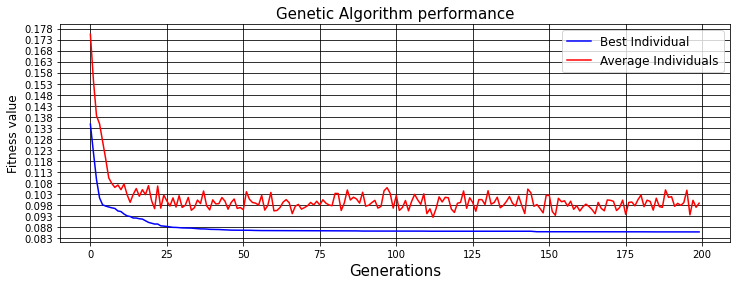

In [17]:
INDIVIDUALS = 200
min_iterations = joblib.load("./results/fobjQuadraticError/iteration{}/best_gen_fitness_iter{}.pkl".format(INDIVIDUALS,INDIVIDUALS))
max_iterations = joblib.load("./results/fobjQuadraticError/iteration{}/worst_gen_fitness_iter{}.pkl".format(INDIVIDUALS,INDIVIDUALS))
avg_iterations = joblib.load("./results/fobjQuadraticError/iteration{}/mean_gen_fitness_iter{}.pkl".format(INDIVIDUALS,INDIVIDUALS))
std_iterations = joblib.load("./results/fobjQuadraticError/iteration{}/std_gen_fitness_iter{}.pkl".format(INDIVIDUALS,INDIVIDUALS))
ind_iterations = joblib.load("./results/fobjQuadraticError/iteration{}/best_gen_individuals_iter{}.pkl".format(INDIVIDUALS,INDIVIDUALS))


x = range(0, len(min_iterations))

plt.figure(figsize=(12,4))

plt.plot(x, min_iterations, 'blue', label = 'Best Individual')
#plt.plot(x, max_iterations, 'black', label = 'Worst Individual')
plt.plot(x, avg_iterations, 'red', label = 'Average Individuals')
#plt.plot(x, std_iterations, 'orange', label = 'Standard Deviation')

plt.grid(True,color='black')
plt.xlabel("Generations", fontsize=15)
plt.xticks(np.arange(0, 201, step=25), fontsize = 10)
plt.yticks(np.arange(0.083, 0.18, step=0.005))
#plt.xlim([2, 300])
plt.ylabel("Fitness value", fontsize=12)
plt.title('Genetic Algorithm performance', fontsize=15)
leg = plt.legend(loc='best', fontsize=12)
plt.show()